In [137]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-


<br>
Goodreads Fantasy Books Exploratory Data Analysis<br>
------------------------------------------------<br>
This script explores various aspects of the Goodreads fantasy books dataset:<br>
1. Basic Statistics and Distributions<br>
2. User Behavior Analysis<br>
3. Book Characteristics<br>
4. Network Analysis<br>
Author: Nicolas<br>


In [138]:
import datetime as dt
import json
import os
from collections import Counter

In [139]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3
from tqdm import tqdm

In [140]:
%matplotlib inline

### Set up SQL SB

Set visualization style

In [141]:
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams.update(
    {
        "font.family": "serif",
        "font.serif": ["Computer Modern Roman"],
        "axes.labelsize": 12,
        "font.size": 11,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)
sns.set(font_scale=1.2)

Pandas display options

In [142]:
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 200)

Data paths

In [143]:
import os

# get current directory
root_dir = "/Users/nicolasdhnr/Documents/Imperial/Imperial Thesis/Code/VULCAN"

DATA_DIR = os.path.join(root_dir, "data")


In [144]:
def connect_to_db(db_path=f"{DATA_DIR}/train.db"):
    """Connect to SQLite database."""
    import sqlite3

    conn = sqlite3.connect(db_path)
    # check if the connection is successfulby printing database tables
    print(conn.execute("SELECT name FROM sqlite_master WHERE type='table'").fetchall())
    return conn


def load_data_from_sqlite(db_path="train.db"):
    """Load data from SQLite database."""
    print("Loading data from database...")
    conn = sqlite3.connect(db_path)

    # Load books
    query_books = "SELECT * FROM books"
    df_books = pd.read_sql_query(query_books, conn)
    print(f"Loaded {len(df_books)} books")

    # Load reviews
    query_reviews = "SELECT * FROM reviews"
    df_reviews = pd.read_sql_query(query_reviews, conn)
    print(f"Loaded {len(df_reviews)} reviews")

    # Note: interactions table has been dropped
    df_interactions = None

    conn.close()
    return df_books, df_reviews, df_interactions


In [145]:
def sql_query(query, db_path=f"{DATA_DIR}/train.db", params=None):
    """Execute SQL query and return results as DataFrame."""
    conn = sqlite3.connect(db_path)
    result = pd.read_sql_query(query, conn, params=params)
    conn.close()
    return result


In [146]:
def load_large_table(table_name, db_path=f"{DATA_DIR}/train.db", chunksize=None):
    """Load a potentially large table with optional chunking.

    Args:
        table_name: Name of the table to load
        db_path: Path to the SQLite database
        chunksize: If provided, returns an iterator of chunks
                   instead of loading all at once

    Returns:
        DataFrame or iterator of DataFrames
    """
    conn = sqlite3.connect(db_path)
    query = f"SELECT * FROM {table_name}"

    if chunksize:
        # Return iterator for processing in chunks
        return pd.read_sql_query(query, conn, chunksize=chunksize)
    else:
        # Load everything at once
        result = pd.read_sql_query(query, conn)
        conn.close()
        return result


def analyze_with_chunking(table_name, analysis_func, chunksize=100000):
    """Apply an analysis function to data loaded in chunks."""
    chunk_iterator = load_large_table(table_name, chunksize=chunksize)
    results = []

    for chunk in chunk_iterator:
        # Process each chunk
        result = analysis_func(chunk)
        results.append(result)

    # Combine results (depends on what analysis_func returns)
    return pd.concat(results) if isinstance(results[0], pd.DataFrame) else results

In [147]:
def explore_data_structure():
    """Print information about the data structure using metadata queries."""
    print("\n--- DATA STRUCTURE EXPLORATION ---")

    # Get table schemas using SQL
    tables = ["books", "reviews"]
    for table in tables:
        columns = sql_query(f"PRAGMA table_info({table})")
        print(f"\n{table.capitalize()} dataset schema:")
        print([col["name"] for col in columns.to_dict("records")])

        # Get row count
        count = sql_query(f"SELECT COUNT(*) as count FROM {table}")
        print(f"Total rows: {count.iloc[0]['count']}")

        # Sample data
        sample = sql_query(f"SELECT * FROM {table} LIMIT 2")
        print(f"\nSample {table} data:")
        print(sample.to_string())


In [148]:
def analyze_user_activity():
    """Analyze user activity distribution using SQL."""
    print("\n--- 1.1 USER ACTIVITY ANALYSIS ---")

    # Get statistics with SQL
    stats_query = """
    SELECT 
        COUNT(DISTINCT user_id) as unique_users,
        AVG(review_count) as mean,
        MIN(review_count) as min,
        MAX(review_count) as max
    FROM (
        SELECT user_id, COUNT(*) as review_count
        FROM reviews
        GROUP BY user_id
    )
    """

    # Get histogram data
    histogram_query = """
    SELECT review_count, COUNT(*) as frequency
    FROM (
        SELECT user_id, COUNT(*) as review_count
        FROM reviews
        GROUP BY user_id
    )
    GROUP BY review_count
    ORDER BY review_count
    """

    # Get top users
    top_users_query = """
    SELECT user_id, COUNT(*) as review_count
    FROM reviews
    GROUP BY user_id
    ORDER BY review_count DESC
    LIMIT 10
    """

    # Execute queries
    stats = sql_query(stats_query)
    histogram_data = sql_query(histogram_query)
    top_users = sql_query(top_users_query)

    # Display results
    print("\nUser Activity Statistics:")
    print(f"Total unique users: {stats['unique_users'].iloc[0]}")
    print(stats)

    # Create list for histogram
    counts_list = []
    for _, row in histogram_data.iterrows():
        counts_list.extend([row["review_count"]] * row["frequency"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(counts_list, bins=50, kde=True)
    plt.title("Distribution of Reviews per User")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Count of Users")

    plt.subplot(1, 2, 2)
    sns.histplot(counts_list, bins=50, kde=True, log_scale=(False, True))
    plt.title("Distribution of Reviews per User (Log Scale)")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Count of Users (Log Scale)")
    plt.tight_layout()

    print("\nTop 10 Most Active Users:")
    print(top_users)


In [149]:
def analyze_book_popularity():
    """Analyze book popularity using SQL."""
    print("\n--- 1.2 BOOK POPULARITY ANALYSIS ---")

    # Get book stats with SQL
    stats_query = """
    SELECT 
        COUNT(DISTINCT book_id) as unique_books,
        AVG(review_count) as mean,
        MIN(review_count) as min,
        MAX(review_count) as max
    FROM (
        SELECT book_id, COUNT(*) as review_count
        FROM reviews
        GROUP BY book_id
    )
    """

    # Get histogram data
    histogram_query = """
    SELECT review_count, COUNT(*) as frequency
    FROM (
        SELECT book_id, COUNT(*) as review_count
        FROM reviews
        GROUP BY book_id
    )
    GROUP BY review_count
    ORDER BY review_count
    """

    # Get top books
    top_books_query = """
    SELECT b.book_id, b.title, b.authors, COUNT(r.book_id) as review_count
    FROM books b
    JOIN reviews r ON b.book_id = r.book_id
    GROUP BY b.book_id
    ORDER BY review_count DESC
    LIMIT 10
    """

    # Execute queries
    stats = sql_query(stats_query)
    histogram_data = sql_query(histogram_query)
    top_books = sql_query(top_books_query)

    # Display results
    print("\nBook Popularity Statistics:")
    print(f"Total unique books with reviews: {stats['unique_books'].iloc[0]}")
    print(stats)

    # Create list for histogram
    counts_list = []
    for _, row in histogram_data.iterrows():
        counts_list.extend([row["review_count"]] * row["frequency"])

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(counts_list, bins=50, kde=True)
    plt.title("Distribution of Reviews per Book")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Count of Books")

    plt.subplot(1, 2, 2)
    sns.histplot(counts_list, bins=50, kde=True, log_scale=(False, True))
    plt.title("Distribution of Reviews per Book (Log Scale)")
    plt.xlabel("Number of Reviews")
    plt.ylabel("Count of Books (Log Scale)")
    plt.tight_layout()

    print("\nTop 10 Most Popular Books:")
    print(top_books)


In [150]:
def analyze_rating_distribution():
    """Analyze rating distribution using SQL."""
    print("\n--- 1.3 RATING DISTRIBUTION ANALYSIS ---")

    # Check if rating column exists
    columns = sql_query("PRAGMA table_info(reviews)")
    if "rating" not in columns["name"].values:
        print("No rating column found in reviews table.")
        return

    # Get basic statistics
    stats_query = """
    SELECT 
        AVG(rating) as mean,
        MIN(rating) as min,
        MAX(rating) as max,
        COUNT(*) as count
    FROM reviews
    WHERE rating IS NOT NULL
    """

    # Get distribution
    dist_query = """
    SELECT rating, COUNT(*) as count
    FROM reviews
    WHERE rating IS NOT NULL
    GROUP BY rating
    ORDER BY rating
    """

    # Execute queries
    stats = sql_query(stats_query)
    dist = sql_query(dist_query)

    # Display results
    print("\nRating Statistics:")
    print(stats)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.barplot(x="rating", y="count", data=dist)
    plt.title("Distribution of Ratings")
    plt.xlabel("Rating")
    plt.ylabel("Count")

    plt.subplot(1, 2, 2)
    plt.bar(dist["rating"], dist["count"])
    plt.title("Rating Distribution")
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.tight_layout()


In [151]:
def analyze_temporal_patterns():
    """Analyze temporal patterns using SQL."""
    print("\n--- 1.4 TEMPORAL PATTERNS ANALYSIS ---")

    # Check if date column exists
    column_check = sql_query("PRAGMA table_info(reviews)")
    has_date = any(col.lower() == "date_added" for col in column_check["name"])

    if not has_date:
        print("No date/time column found for temporal analysis.")
        return

    # Monthly data
    monthly_query = """
    SELECT 
        strftime('%Y-%m', date_added) as year_month,
        COUNT(*) as interaction_count
    FROM reviews
    WHERE date_added IS NOT NULL
    GROUP BY year_month
    ORDER BY year_month
    """

    # Yearly data
    yearly_query = """
    SELECT 
        strftime('%Y', date_added) as year,
        COUNT(*) as interaction_count
    FROM reviews
    WHERE date_added IS NOT NULL
    GROUP BY year
    ORDER BY year
    """

    # Execute queries
    monthly_data = sql_query(monthly_query)
    yearly_data = sql_query(yearly_query)

    # Plot monthly trend
    plt.figure(figsize=(14, 6))
    plt.plot(
        monthly_data["year_month"],
        monthly_data["interaction_count"],
        marker="o",
        linestyle="-",
        alpha=0.7,
    )
    plt.title("Monthly Interactions with Fantasy Books")
    plt.xlabel("Date")
    plt.ylabel("Number of Interactions")
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Yearly trend
    plt.figure(figsize=(12, 6))
    plt.bar(yearly_data["year"], yearly_data["interaction_count"])
    plt.title("Yearly Interactions with Fantasy Books")
    plt.xlabel("Year")
    plt.ylabel("Number of Interactions")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    print("\nTemporal analysis completed.")


In [152]:
def analyze_user_reading_patterns(df_reviews):
    """Analyze user reading patterns over time."""
    print("\n--- 2.1 USER READING PATTERNS ANALYSIS ---")

    # Check for date column in reviews instead of interactions
    date_col = "date_added" if "date_added" in df_reviews.columns else None
    if not date_col:
        print("No date/time column found for reading pattern analysis.")
        return
    try:
        # Convert to datetime
        df_reviews[date_col] = pd.to_datetime(df_reviews[date_col], errors="coerce")

        # Drop rows with invalid dates
        df_time = df_reviews.dropna(subset=[date_col])

        # Group by user and month
        df_time["year_month"] = df_time[date_col].dt.to_period("M")
        books_per_user_per_month = (
            df_time.groupby(["user_id", "year_month"])["book_id"].count().reset_index()
        )
        books_per_user_per_month.columns = ["user_id", "year_month", "books_count"]

        # Calculate average books per user per month
        avg_books_per_month = books_per_user_per_month["books_count"].mean()
        median_books_per_month = books_per_user_per_month["books_count"].median()
        print(f"\nAverage books per user per month: {avg_books_per_month:.2f}")
        print(f"Median books per user per month: {median_books_per_month:.2f}")

        # Plot distribution
        plt.figure(figsize=(12, 6))
        sns.histplot(books_per_user_per_month["books_count"], bins=30, kde=True)
        plt.axvline(
            avg_books_per_month,
            color="red",
            linestyle="--",
            label=f"Mean = {avg_books_per_month:.2f}",
        )
        plt.axvline(
            median_books_per_month,
            color="green",
            linestyle="-",
            label=f"Median = {median_books_per_month:.2f}",
        )
        plt.title("Distribution of Books Read per User per Month")
        plt.xlabel("Number of Books")
        plt.ylabel("Count")
        plt.legend()

        # Yearly analysis
        df_time["year"] = df_time[date_col].dt.year
        books_per_user_per_year = (
            df_time.groupby(["user_id", "year"])["book_id"].count().reset_index()
        )
        books_per_user_per_year.columns = ["user_id", "year", "books_count"]
        avg_books_per_year = books_per_user_per_year["books_count"].mean()
        median_books_per_year = books_per_user_per_year["books_count"].median()
        print(f"\nAverage books per user per year: {avg_books_per_year:.2f}")
        print(f"Median books per user per year: {median_books_per_year:.2f}")
        print("\nReading patterns analysis completed and saved as images.")
    except Exception as e:
        print(f"Error in reading patterns analysis: {e}")

In [153]:
def analyze_user_rating_behavior(df_interactions, df_reviews):
    """Analyze user rating behavior."""
    print("\n--- 2.2 USER RATING BEHAVIOR ANALYSIS ---")

    # Check if ratings are available
    if "rating" in df_interactions.columns and "user_id" in df_interactions.columns:
        df_ratings = df_interactions[["user_id", "book_id", "rating"]].dropna(
            subset=["rating"]
        )
        rating_source = "interactions"
    elif "rating" in df_reviews.columns and "user_id" in df_reviews.columns:
        df_ratings = df_reviews[["user_id", "book_id", "rating"]].dropna(
            subset=["rating"]
        )
        rating_source = "reviews"
    else:
        print("No rating data available for user rating behavior analysis.")
        return
    try:
        # Calculate user rating statistics
        user_rating_stats = (
            df_ratings.groupby("user_id")["rating"]
            .agg(["count", "mean", "std", "min", "max"])
            .reset_index()
        )
        user_rating_stats = user_rating_stats[
            user_rating_stats["count"] >= 5
        ]  # Users with at least 5 ratings
        print(f"\nUser Rating Behavior Statistics (from {rating_source}):")
        print(user_rating_stats.describe().to_string())

        # Plot distribution of mean ratings
        plt.figure(figsize=(12, 6))
        sns.histplot(user_rating_stats["mean"], bins=30, kde=True)
        plt.title("Distribution of User Average Ratings")
        plt.xlabel("Average Rating")
        plt.ylabel("Count of Users")

        # Plot distribution of rating standard deviations
        plt.figure(figsize=(12, 6))
        sns.histplot(user_rating_stats["std"].dropna(), bins=30, kde=True)
        plt.title("Distribution of User Rating Standard Deviations")
        plt.xlabel("Standard Deviation")
        plt.ylabel("Count of Users")

        # User rating bias
        overall_mean_rating = df_ratings["rating"].mean()
        user_rating_stats["rating_bias"] = (
            user_rating_stats["mean"] - overall_mean_rating
        )
        print(f"\nOverall mean rating: {overall_mean_rating:.2f}")
        print(
            "\nTop 5 Users with Positive Rating Bias (rate books higher than average):"
        )
        print(
            user_rating_stats.nlargest(5, "rating_bias")[
                ["user_id", "count", "mean", "rating_bias"]
            ].to_string()
        )
        print(
            "\nTop 5 Users with Negative Rating Bias (rate books lower than average):"
        )
        print(
            user_rating_stats.nsmallest(5, "rating_bias")[
                ["user_id", "count", "mean", "rating_bias"]
            ].to_string()
        )
        print("\nUser rating behavior analysis completed and saved as images.")
    except Exception as e:
        print(f"Error in user rating behavior analysis: {e}")

In [154]:
def analyze_publication_trends():
    """Analyze publication year trends using SQL with improved error handling."""
    print("\n--- 3.2 PUBLICATION YEAR TRENDS ---")

    # Check for publication year column
    columns = sql_query("PRAGMA table_info(books)")
    pub_year_cols = [
        col
        for col in columns["name"]
        if ("year" in col.lower() and "pub" in col.lower())
        or "published" in col.lower()
    ]

    if not pub_year_cols:
        print("No publication year column found.")
        return

    pub_year_col = pub_year_cols[0]

    # First, check for extreme outliers
    outliers_query = f"""
    SELECT MIN({pub_year_col}) as min_year, MAX({pub_year_col}) as max_year
    FROM books
    WHERE {pub_year_col} IS NOT NULL
    """

    outliers = sql_query(outliers_query)
    min_year = outliers["min_year"].iloc[0]
    max_year = outliers["max_year"].iloc[0]

    print(f"Raw publication year range: {min_year} to {max_year}")

    # Define a reasonable range for publication years (e.g., 1500 to current year + 5)
    import datetime

    current_year = datetime.datetime.now().year
    valid_min_year = 1
    valid_max_year = current_year + 5

    # Stats query with proper filtering
    stats_query = f"""
    SELECT 
        AVG({pub_year_col}) as mean,
        MIN({pub_year_col}) as min,
        MAX({pub_year_col}) as max,
        COUNT(*) as count
    FROM books
    WHERE 
        {pub_year_col} IS NOT NULL
        AND {pub_year_col} >= {valid_min_year}
        AND {pub_year_col} <= {valid_max_year}
    """

    # Distribution query with proper filtering
    dist_query = f"""
    SELECT {pub_year_col} as year, COUNT(*) as count
    FROM books
    WHERE 
        {pub_year_col} IS NOT NULL
        AND {pub_year_col} >= {valid_min_year}
        AND {pub_year_col} <= {valid_max_year}
    GROUP BY year
    ORDER BY year
    """

    # Decade analysis query with proper filtering
    decade_query = f"""
    SELECT 
        CAST(({pub_year_col} / 10) * 10 AS INTEGER) as decade,
        AVG(average_rating) as avg_rating,
        COUNT(*) as book_count
    FROM books
    WHERE 
        {pub_year_col} IS NOT NULL
        AND {pub_year_col} >= {valid_min_year}
        AND {pub_year_col} <= {valid_max_year}
        AND average_rating IS NOT NULL
    GROUP BY decade
    ORDER BY decade
    """

    # Data quality check query
    quality_check_query = f"""
    SELECT {pub_year_col} as year, COUNT(*) as count
    FROM books
    WHERE {pub_year_col} IS NOT NULL
    GROUP BY 
        CASE 
            WHEN {pub_year_col} < {valid_min_year} THEN 'too_old'
            WHEN {pub_year_col} > {valid_max_year} THEN 'future'
            ELSE 'valid'
        END
    """

    # Execute queries
    quality_check = sql_query(quality_check_query)
    stats = sql_query(stats_query)
    dist = sql_query(dist_query)
    decades = sql_query(decade_query)

    # Print data quality information
    print("\nPublication Year Data Quality Check:")
    print(quality_check)
    print(f"\nAnalyzing only years between {valid_min_year} and {valid_max_year}")

    # Display results
    print("\nValid Publication Year Statistics:")
    print(stats)

    # Plot distribution
    plt.figure(figsize=(14, 6))
    plt.bar(dist["year"], dist["count"])
    plt.title(f"Distribution of Publication Years ({valid_min_year}-{valid_max_year})")
    plt.xlabel("Publication Year")
    plt.ylabel("Count of Books")

    # Plot decade ratings
    if not decades.empty:
        plt.figure(figsize=(12, 6))
        plt.bar(decades["decade"].astype(str), decades["avg_rating"])
        plt.title("Average Rating by Publication Decade")
        plt.xlabel("Publication Decade")
        plt.ylabel("Average Rating")
        plt.tight_layout()

        print("\nAverage Rating by Publication Decade:")
        print(decades)

    # Check if we filtered out significant data
    filtered_count = sql_query(f"""
        SELECT COUNT(*) as count FROM books 
        WHERE {pub_year_col} IS NULL 
           OR {pub_year_col} < {valid_min_year} 
           OR {pub_year_col} > {valid_max_year}
    """)

    total_count = sql_query("SELECT COUNT(*) as count FROM books")

    filtered_percentage = (
        filtered_count.iloc[0]["count"] / total_count.iloc[0]["count"]
    ) * 100
    print(
        f"\nFiltered out {filtered_count.iloc[0]['count']} books ({filtered_percentage:.2f}%) with missing or invalid publication years"
    )


## 1.Explore the Data Structure


In [155]:
explore_data_structure()



--- DATA STRUCTURE EXPLORATION ---

Books dataset schema:
['language_code', 'average_rating', 'description', 'authors', 'publisher', 'num_pages', 'publication_year', 'book_id', 'ratings_count', 'title']
Total rows: 258585

Sample books data:
  language_code  average_rating                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

## 2. User Data Analysis

In [156]:
analyze_user_activity()
analyze_book_popularity()
analyze_rating_distribution()


--- 1.1 USER ACTIVITY ANALYSIS ---

User Activity Statistics:
Total unique users: 62307
   unique_users       mean  min   max
0         62307  30.390277    5  2246


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

Error in callback <function _draw_all_if_interactive at 0x107c6f6a0> (for post_execute), with arguments args (),kwargs {}:


FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

FileNotFoundError: Matplotlib's TeX implementation searched for a file named 'cmss12.tfm' in your texmf tree, but could not find it

<Figure size 1200x600 with 2 Axes>

## 3. Book Characteristics Analysis


--- 3.2 PUBLICATION YEAR TRENDS ---
Raw publication year range:  to 8

Publication Year Data Quality Check:
   year   count
0  2994      45
1         62511
2  1987  196029

Analyzing only years between 1 and 2030

Valid Publication Year Statistics:
          mean   min   max   count
0  2009.779405  1014  2030  196029

Average Rating by Publication Decade:
    decade  avg_rating  book_count
0        0    4.360000           2
1       10    4.011351          37
2       20    3.900000           2
3      160    3.790000           1
4      190    3.940000           1
5      200    3.862000           5
6     1010    4.090000           2
7     1190    3.580000           1
8     1380    3.522000           5
9     1390    3.905714           7
10    1810    4.080000           1
11    1820    3.500000           1
12    1840    3.330000           1
13    1850    3.615000           2
14    1860    4.000000           1
15    1870    3.830000           2
16    1880    3.665000           2
17    1890 

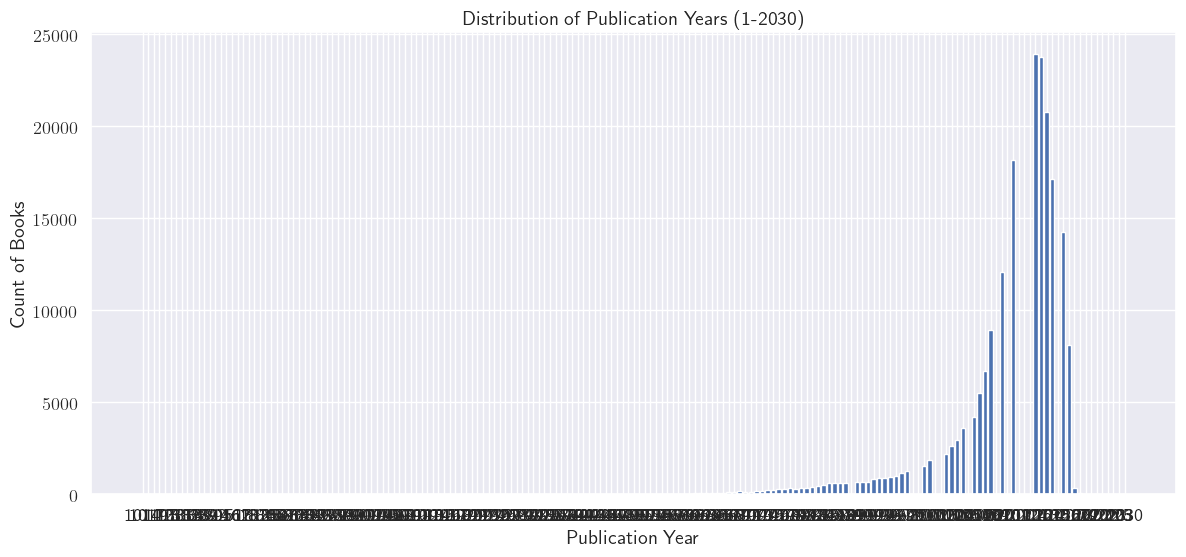

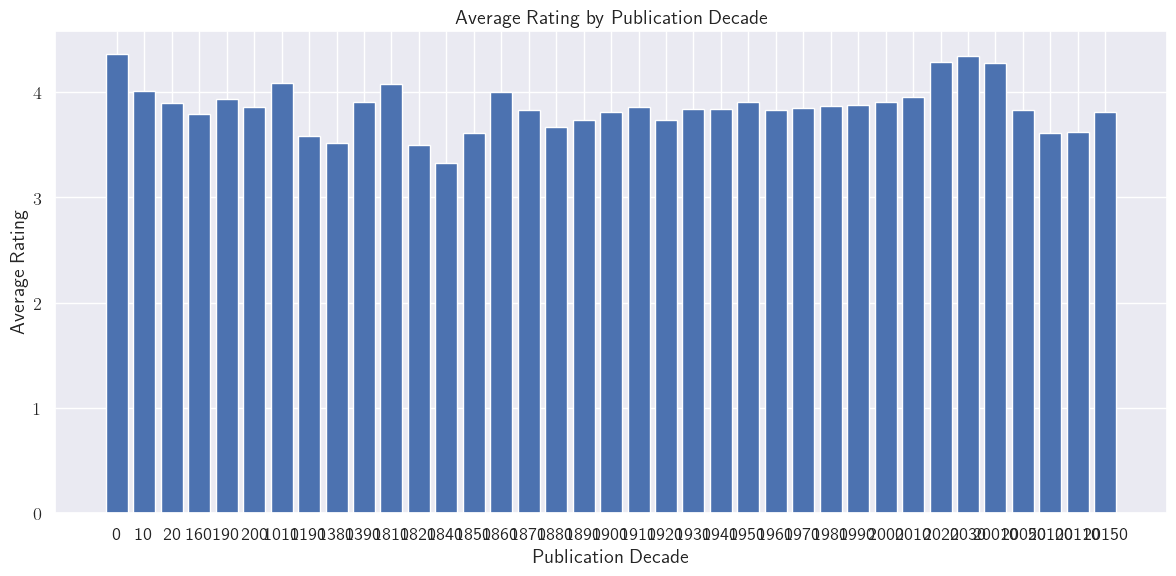

In [219]:
analyze_publication_trends()